Optimized prediction model. 


1.   Optimal found parameters MULTIVARIATE: 2 lag order, 7 neurons
2.   Optimal found parameters UNIVARIATE: 7 lag order, 3 neurons




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
import keras

Function to transform csv in supervised learning dataset

In [ ]:
"""Learning to supervised model"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Load the csv file (should be repeated for each room)



In [ ]:
room = pd.read_csv('/home/ict4bd/Residential_oslo/simulation_data/total.csv', parse_dates=[0,], index_col="Date_Time")
prediction = pd.DataFrame()
prediction['Date'] = room.index
number_features = len(room.columns)

In [ ]:
#ONLY IF WE WANT TO STUDY UNIVARIATE BEHAVIOUR
#drop all the columns except for the internal temperature
room = room.drop(['t_out', 'power_heating', 'power_cooling', 'solar_rad'], axis=1) 

Plot of the time series considered in every csv. The correct name of the column should be placed if changing input csv

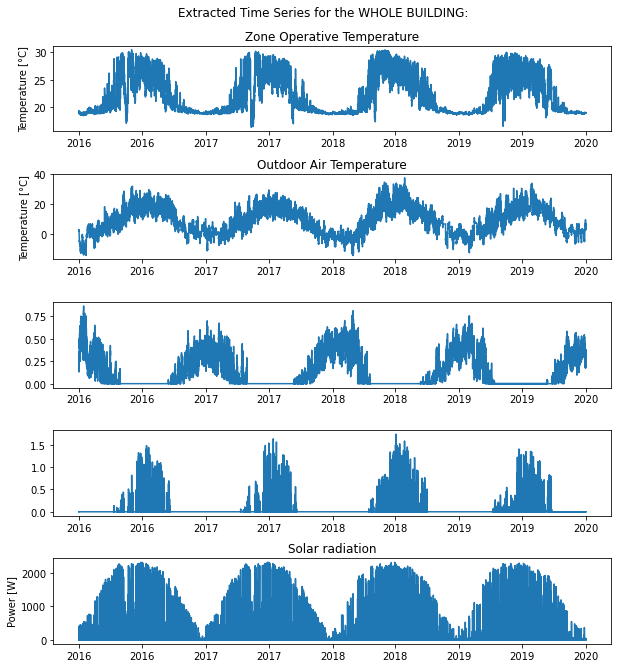

In [ ]:
#plot of the time series considered in every csv. The correct name of the column should be placed
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y')

values = room.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
fig = plt.figure(figsize=(10,11))

for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(room.index,values[:, group])
  if(room.columns[group] == 't_in'):
    plt.title('Zone Operative Temperature', y = 1, loc='center')
    plt.ylabel('Temperature [°C]')
  if(room.columns[group] == 't_out'):
    plt.title('Outdoor Air Temperature', y = 1, loc='center')
    plt.ylabel('Temperature [°C]')
  if(room.columns[group] == 'power_cooling'):
    plt.title('Power Cooling', y = 1, loc='center')
    plt.ylabel('Power [kWh]')
  if(room.columns[group] == 'power_heating'):
    plt.title('Power Heating', y = 1, loc='center')
    plt.ylabel('Power [kWh]')
  if(room.columns[group] == 'solar_rad'):
    plt.title('Solar radiation', y = 1, loc='center')
    plt.ylabel('Power [W]')

  plt.gca().xaxis.set_major_formatter(myFmt)
  plt.xticks(rotation = 0)
  i = i+1

fig.suptitle('Extracted Time Series for the WHOLE BUILDING:', y = 0.93)
fig.subplots_adjust(hspace=0.5)
plt.show()

Creating the dataset, number of future values to be predicted is 12, ie. up to three hours

In [ ]:
values = room.values #change this according to the room in study
values = values.astype('float32') # ensure all data is float
number_future_samples = 20 #up to five hours
number_past_values = 2 #7 in case of univariate

#preparation of the dataset
reframed = series_to_supervised(values, number_past_values, number_future_samples)
input_past_values = reframed.iloc[:,0:number_past_values * number_features]
output_future_values = reframed.iloc[:,number_past_values * number_features:]
output_future_values = reframed.filter(regex=r'(var1\(t\+|var1\(t\))')
prepared_dataset = pd.concat([input_past_values, output_future_values], axis = 1 )
prepared_dataset

In [ ]:
#Splitting dataset into training tand test set
to_be_scaled_values = prepared_dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(to_be_scaled_values)
n_train_hours = 3 * 365 * 24 * 4  #number of quaters of hour in 3 years time 

train = scaled_values[:n_train_hours, :]
test = scaled_values[n_train_hours:, :]
train_X, train_y = train[:, :-(number_future_samples)], train[:, -(number_future_samples):]
test_X, test_y = test[:, :-(number_future_samples)], test[:, -(number_future_samples):]

Creating the model: (replace the correct number of neurons if there are any changes)

In [ ]:
#Definition of the model
model = Sequential()
model.add(Dense(7, activation='sigmoid', input_dim = train_X.shape[1],kernel_initializer='random_normal')) 
model.add(Dense(number_future_samples))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mae')


Test the model three times. The final prediction will be the average of the three.

In [ ]:
yhat_list = np.zeros((test_X.shape[0],number_future_samples))
j = 0
for i in range (1,4):
  history = model.fit(train_X, train_y, epochs = 100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  print('Prediction number %d completed!' %i)
  #Prediction
  yhat = model.predict(test_X)
  yhat_list = yhat_list + yhat
  j = j + 1
yhat = yhat_list/j #average of three prediction to reduce the error

Prediction number 1 completed!
Prediction number 2 completed!
Prediction number 3 completed!


In [ ]:
#Invert scaling of the test vector 
inv_test_y = concatenate((test_X,test_y),axis = 1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,-number_future_samples:]

In [ ]:
 #Invert scaling predicted y_hat
inv_yhat = concatenate((test_X,yhat),axis = 1)
inv_yhat = np.array(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-number_future_samples:]

In [ ]:
for i in range(test_y.shape[1]):
  plt.figure(figsize=(5,3))
  plt.plot(inv_yhat[:,i], label = "Predicted")
  plt.plot(inv_test_y[:,i], label = "Real")
  plt.legend()
  plt.title('Real vs prediction with with future sample (t + %d)' %i)
  plt.show()

In [ ]:
print('MEAN ABSOLUTE ERROR EVALUATION')
mae_list = []
for i in range (inv_yhat.shape[1]):
  mae = mean_absolute_error(inv_test_y[:,i],inv_yhat[:,i])
  mae_list.append(mae)
  #print('MSE with %d future steps: %f' %(i,mae))
  print(round(mae,3))
mae_list = np.array(mae_list)
print('prova %.2f' %mae_list.mean())

In [ ]:
print('MEAN SQUARE ERROR EVALUATION')
mse_list = []
for i in range (inv_yhat.shape[1]):
  mse = math.sqrt(mean_squared_error(inv_test_y[:,i],inv_yhat[:,i]))
  mse_list.append(mse)
  #print('MSE with %d future steps: %f' %(i,mae))
  print(round(mse,3))

In [ ]:
print('Coefficient of determination')
r2_list = []
for i in range (inv_yhat.shape[1]):
  r2 = r2_score(inv_test_y[:,i],inv_yhat[:,i])
  r2_list.append(mae)
  print(round(r2,3))

In [ ]:
#PLOT PREDICTION WITH TOLLERANCE MAE for the first week of february
#Change the values selected according to the MAE limits of 0.750, total.csv for example k = 16
import matplotlib.dates as mdates

prediction_2019 = pd.DataFrame(prediction.iloc[n_train_hours:-21,:])
prediction_2019['Real_Data'] = inv_test_y[:,16:17] #value of k, to be changed according to the room
prediction_2019['Estimated_Data'] = inv_yhat[:,16:17]
print(type(prediction_2019.index))


start_date = pd.to_datetime('2019-02-01 00:00:00')
end_date = pd.to_datetime('2019-02-08 00:00:00')

mask = (prediction_2019['Date'] > start_date) & (prediction_2019['Date'] <= end_date)
prediction_2019 = prediction_2019.loc[mask]
prediction_2019['Date'] = pd.to_datetime(prediction_2019['Date'])
prediction_2019.index = prediction_2019['Date']
prediction_2019 = prediction_2019.resample('H').mean()

prova = (prediction_2019.resample('D').mean()).index

plt.figure()
plt.title('Real temperature and 16-step ahead prediction - multivariate')
plt.plot(prediction_2019['Real_Data'],label = 'Real')
plt.plot(prediction_2019.index,prediction_2019['Estimated_Data'],label = 'Predicted')
plt.legend()
plt.grid()
plt.xticks(prova)
plt.xlabel('Date',labelpad = 10)
plt.ylabel('Indoor air temperature',labelpad = 10)
plt.gcf().autofmt_xdate()
plt.xticks(rotation = 45)
plt.show()
